In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
path = "Brent_crude_oil.csv"
brent_df=pd.read_csv(path)

In [4]:
brent_df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/01/2010,80.120003,79.82,80.120003,80.120003,80.120003,97.0


In [5]:
brent_df.dropna(inplace = True)

In [6]:
brent_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df1=brent_df.copy()

In [8]:
df1["Date"]=pd.to_datetime(brent_df["Date"],format='%d/%m/%Y')
df1.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,80.120003,79.82,80.120003,80.120003,80.120003,97.0


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2485 entries, 0 to 3066
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2485 non-null   datetime64[ns]
 1   Open       2485 non-null   float64       
 2   High       2485 non-null   float64       
 3   Low        2485 non-null   float64       
 4   Close      2485 non-null   float64       
 5   Adj Close  2485 non-null   float64       
 6   Volume     2485 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 155.3 KB


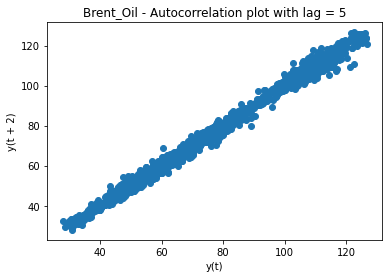

In [10]:
plt.figure()
lag_plot(df1['Close'], lag=2)
plt.title('Brent_Oil - Autocorrelation plot with lag = 5')
plt.show()

We can now confirm that ARIMA is going to be a good model to be applied to this type of data (there is auto-correlation in the data).
Finally, let’s plot the stock price evolution over time.

In [11]:
# df1

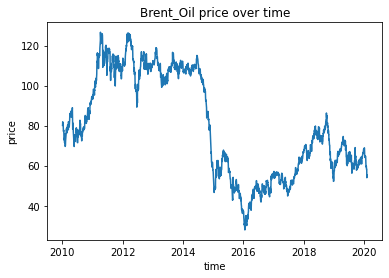

In [12]:
plt.plot(df1["Date"], df1["Close"])
# plt.xticks(np.arange(0,2485,100), df1['Date'][0:2485:100])
plt.title("Brent_Oil price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [13]:
We need adFuller test to determine the data is stationary or not.If the series is non-stationary using ADF,then d is required.

SyntaxError: invalid syntax (<ipython-input-13-1e1bab746078>, line 1)

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
series=df1['Close']
series

0       80.120003
1       80.589996
2       81.889999
3       81.510002
4       81.370003
          ...    
3061    58.290001
3062    58.160000
3064    58.200001
3065    53.959999
3066    55.279999
Name: Close, Length: 2485, dtype: float64

In [16]:

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):
#Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
        if pvalue < cutoff:
          print('p-value = %.4f. The series is likely stationary.' % pvalue)
        else:
          print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

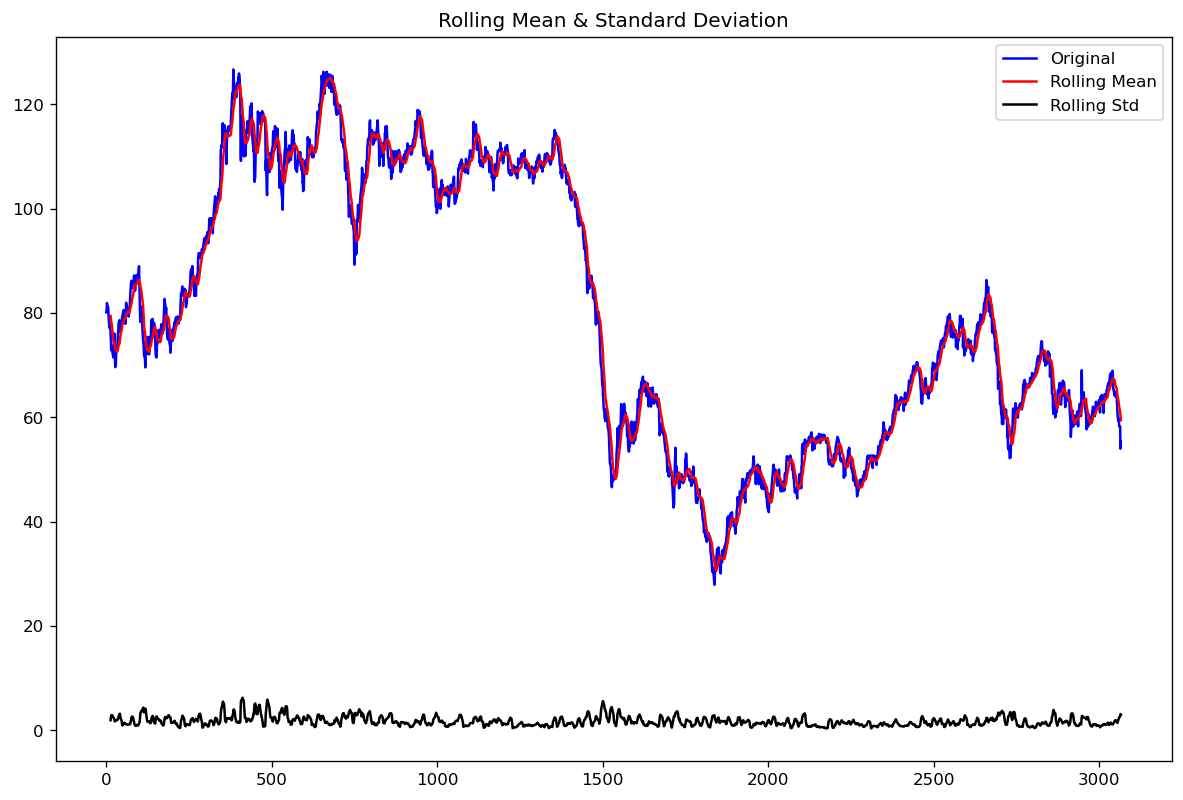

Results of Dickey-Fuller Test:
p-value = 0.7296. The series is likely non-stationary.
p-value = 0.7296. The series is likely non-stationary.
p-value = 0.7296. The series is likely non-stationary.
Test Statistic                   -1.062977
p-value                           0.729608
#Lags Used                        2.000000
Number of Observations Used    2482.000000
Critical Value (1%)              -3.432987
Critical Value (5%)              -2.862705
Critical Value (10%)             -2.567390
dtype: float64


In [32]:
test_stationarity(series)

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

import numpy as np

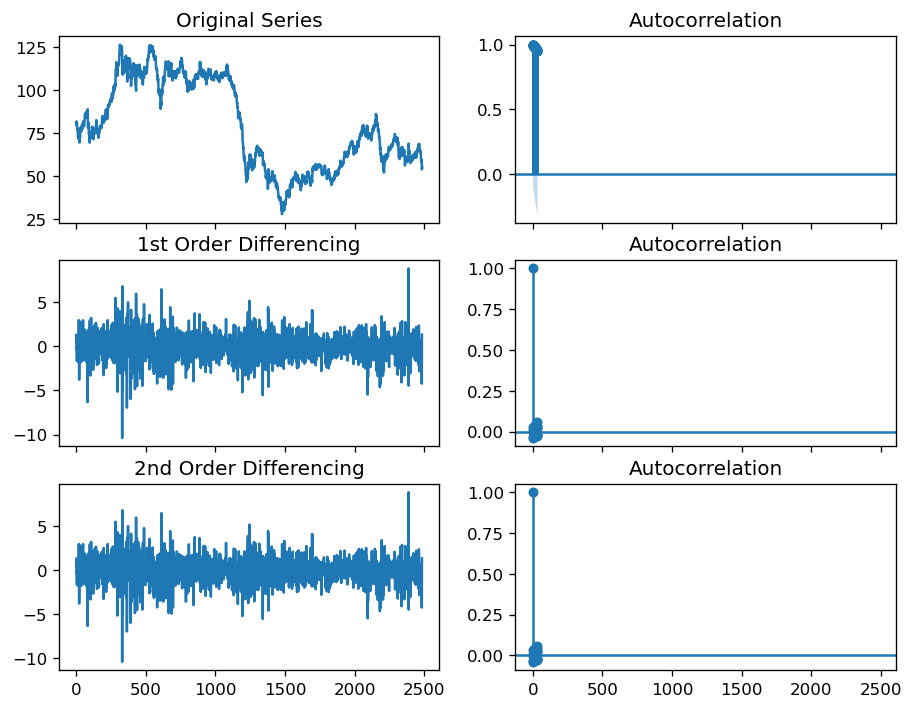

In [29]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df1["Close"].values); axes[0, 0].set_title('Original Series')
plot_acf(df1["Close"].values, ax=axes[0, 1])


# 1st Differencing
axes[1, 0].plot(np.diff(df1["Close"].values)); axes[1, 0].set_title('1st Order Differencing')
df1=df1.dropna()
plot_acf(np.diff(df1["Close"].values), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(df1["Close"].values)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(df1["Close"].values), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

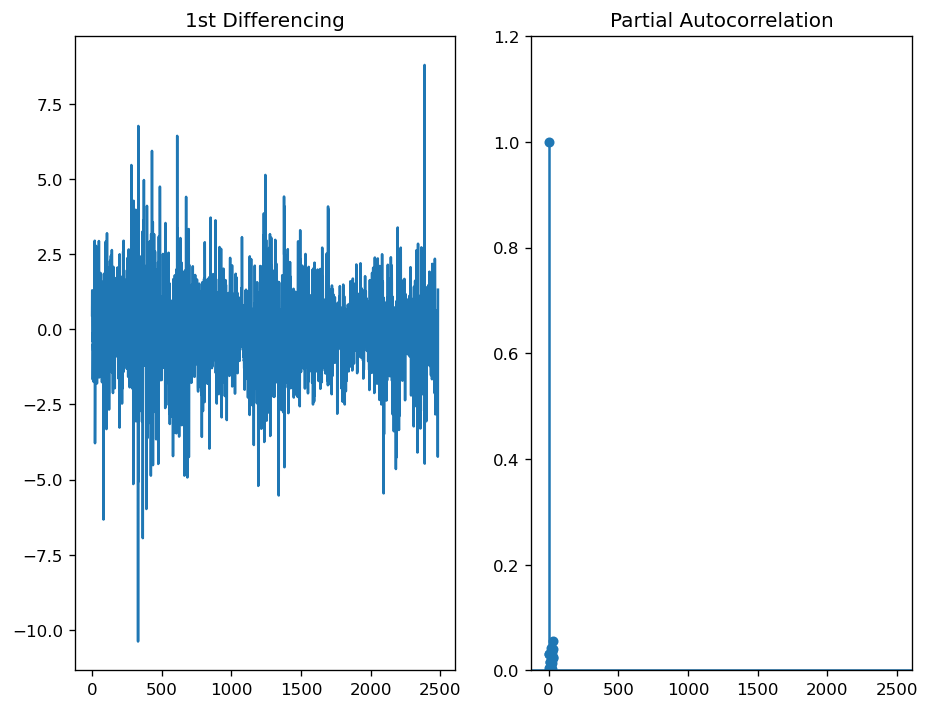

In [30]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(df1["Close"].values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_pacf(np.diff(df1["Close"].values), ax=axes[1])

plt.show()

Both PACF and ACF decays the auto-correlation to 0 quickly from +1.Also, couple of lags are well above the significance line. So, let’s tentatively fix q as 0. When in doubt, go with the simpler model that sufficiently explains the Y.

Next, let’s divide the data into a training (80 % ) and test (20%) set. For this tutorial we select the following ARIMA parameters: p=5, d=1 and q=0.

In [21]:
train_data, test_data = df1[0:int(len(df1)*0.8)], df1[int(len(df1)*0.8):]

In [22]:
training_data = train_data['Close'].values
test_data = test_data['Close'].values

history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

  
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1.6356322713746925


In [23]:
print(model_fit.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2483
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4306.170
Method:                       css-mle   S.D. of innovations              1.371
Date:                Sat, 20 Feb 2021   AIC                           8620.340
Time:                        14:38:58   BIC                           8643.609
Sample:                             1   HQIC                          8628.791
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0104      0.026     -0.408      0.683      -0.061       0.040
ar.L1.D.y     -0.0399      0.020     -1.986      0.047      -0.079      -0.001
ar.L2.D.y     -0.0336      0.020     -1.672      0.095      -0.073       0.006
  

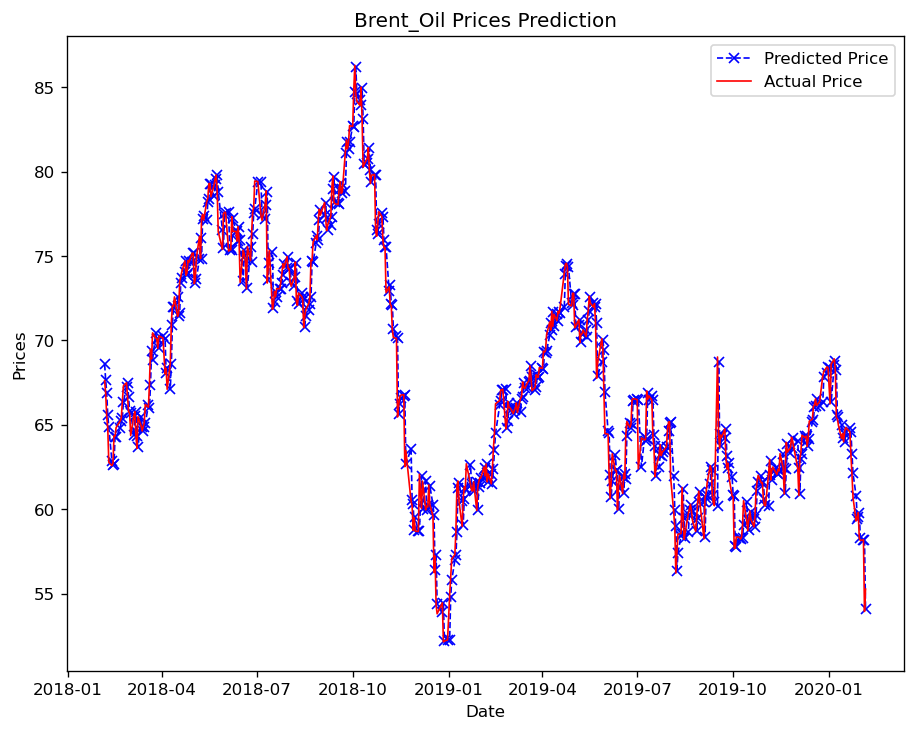

In [31]:
test_set_range = df1[int(len(df1)*0.8):].Date
plt.plot(test_set_range, model_predictions, color='blue', marker='x', linestyle='dashed',label='Predicted Price', lw=1)
plt.plot(test_set_range, test_data, color='red', label='Actual Price', lw=1)
plt.title('Brent_Oil Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')

plt.legend()
plt.show()

In [33]:
date_df=pd.DataFrame(df1[int(len(df1)*0.8):].Date)
df_test = pd.DataFrame(data=test_data)
df_preds = pd.DataFrame(data=model_predictions)

display(date_df.head(3), df_test.head(3), df_preds.head(3))

,Date
2459,2018-02-05
2460,2018-02-06
2461,2018-02-07


,0
0,67.620003
1,66.860001
2,65.510002


,0
0,68.589192
1,67.660431
2,66.907846


In [34]:
date_df.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_preds.reset_index(drop=True, inplace=True)

df_preds = df_preds.shift(periods=+1)

# p = p.iloc[:-1]
# t = t.iloc[:-1]

frames=[date_df['Date'],df_test[0],df_preds[0]]
headers=['Date','test','preds']
graphdata= pd.concat(frames, axis=1, keys=headers)

# graphdata = df_test.merge(df_preds, how='inner', suffixes=('_actual', '_prediction'))
graphdata

,Date,test,preds
0,2018-02-05,67.620003,NaN
1,2018-02-06,66.860001,68.589192
2,2018-02-07,65.510002,67.660431
3,2018-02-08,64.809998,66.907846
4,2018-02-09,62.790001,65.569272
...,...,...,...
492,2020-01-30,58.290001,59.539444
493,2020-01-31,58.160000,59.782831
494,2020-02-03,58.200001,58.331118
495,2020-02-04,53.959999,58.206898


In [35]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure([

    go.Scatter(
        name='Actual',
        x=graphdata.Date,
        y=graphdata['test'],
        mode='lines',
        marker=dict(color="#008080"),
        line=dict(width=1),
        showlegend=True
    ),
    go.Scatter(
        name='Prediction',
        x=graphdata.Date,
        y=graphdata['preds'],
        marker=dict(color="#FF8C00"),
        line=dict(width=1),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        showlegend=True
    )
])

fig.update_layout(
    yaxis_title='',
    title='',
    hovermode="x"
)

fig.show()